# Chest X-Ray (Pneumonia): Dataset EDA

This Notebook analyzes the X-Ray dataset \
For further information on this work see the article https://arxiv.org/abs/1711.05225 which is one of the first articles on this subject \
Download the whole dataset from the provided link
Check Kaggle competition as well : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### Dataset Information

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [1]:
import pandas as pd       
import matplotlib as mat

import numpy as np
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
pd.options.display.max_colwidth = 100

import random
import os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import glob
import cv2
from PIL import Image

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

import sys
sys.stderr = open('err.txt', 'w')

2025-02-18 11:31:50.726752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 11:31:50.737090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 11:31:50.739873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42
main_path = "./chest_xray_data/"

In [3]:
# folder input structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------PNEUMONIA
#                  !-------------NORMAL
#


normal = glob.glob(main_path+"/normal/*.jpeg")
pneumo = glob.glob(main_path+"/pneumonia/*.jpeg")

print('There are normal', len(normal), 'images')
print('There are pneumonia', len(pneumo), 'images')

There are normal 1583 images
There are pneumonia 4273 images


In [4]:
# creation of 3 dataframes train, test, val for easy handling ana analysis

fnormal = glob.glob(main_path+"TRAIN/NORMAL/*.jpeg")
fpneumo = glob.glob(main_path+"TRAIN/PNEUMONIA/*.jpeg")

df_normal = pd.DataFrame(['Normal']*len(fnormal))
normal_list = [x for x in fnormal]
df_normal['image'] = normal_list

df_pneumo = pd.DataFrame(['Pneumonia']*len(fpneumo))
pneumo_list = [x for x in fpneumo]
df_pneumo['image'] = pneumo_list

df_total  = pd.concat([df_pneumo, df_normal], ignore_index=True)
df_total.columns = ['class','image']
print('File shape:', df_total.shape, 'Normal shape:', df_normal.shape, 'Penumonia shape', df_pneumo.shape)

File shape: (4099, 2) Normal shape: (1108, 2) Penumonia shape (2991, 2)


In [5]:
df_total

,class,image
0,Pneumonia,./chest_xray_data/TRAIN/PNEUMONIA/person1302_bacteria_3266.jpeg
1,Pneumonia,./chest_xray_data/TRAIN/PNEUMONIA/person805_bacteria_2712.jpeg
2,Pneumonia,./chest_xray_data/TRAIN/PNEUMONIA/person1218_bacteria_3171.jpeg
3,Pneumonia,./chest_xray_data/TRAIN/PNEUMONIA/person111_virus_209.jpeg
4,Pneumonia,./chest_xray_data/TRAIN/PNEUMONIA/person1087_bacteria_3027.jpeg
...,...,...
4094,Normal,./chest_xray_data/TRAIN/NORMAL/NORMAL2-IM-0395-0001-0002.jpeg
4095,Normal,./chest_xray_data/TRAIN/NORMAL/NORMAL2-IM-0881-0001.jpeg
4096,Normal,./chest_xray_data/TRAIN/NORMAL/IM-0598-0001.jpeg
4097,Normal,./chest_xray_data/TRAIN/NORMAL/IM-0350-0001.jpeg


### Data Exploration

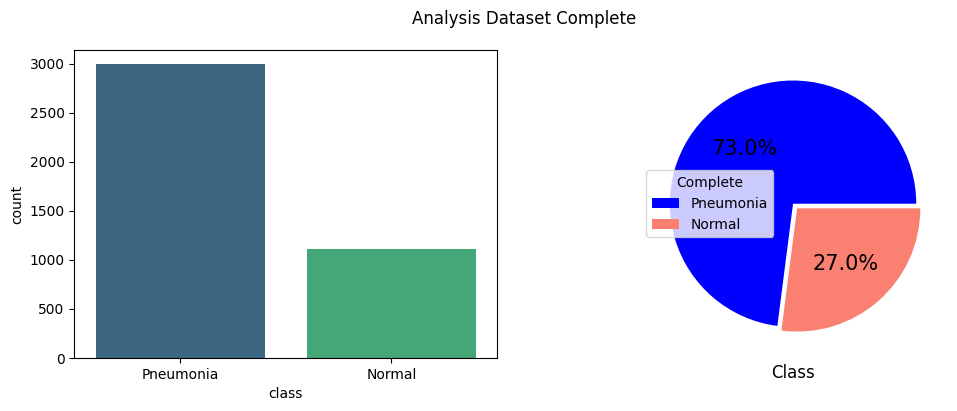

In [6]:
# Visualizes dataframe structure with 2 plots

def visualizing_data(df, Name_title):

   fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    
   fig.suptitle('Analysis Dataset '+ Name_title)
   sns.countplot(x='class', data=df, palette="viridis", ax = axes[0])
   axes[0] = plt.xlabel("Class", fontsize= 12)


   axes[1] = plt.pie(df['class'].value_counts(), labels = ['',''],colors = ['blue','salmon'], 
                      explode = [0,0.05], textprops = {"fontsize":15},autopct='%1.1f%%')

   axes[1]= plt.legend(labels=['Pneumonia', 'Normal'])
   axes[1].set_title(Name_title)
   plt.show()
   return

visualizing_data(df_total,'Complete') 

### Internal structure of the raw data

In [7]:
sample_image = cv2.imread(df_total.iloc[0]['image'])

print('Raw image shape :', sample_image.shape)


Raw image shape : (624, 1056, 3)


In [8]:
df_total['matrix'] = df_total['image'].apply(lambda x: np.asarray(Image.open(x)))
df_total['shapes'] = df_total['matrix'].apply(lambda x: x.shape)

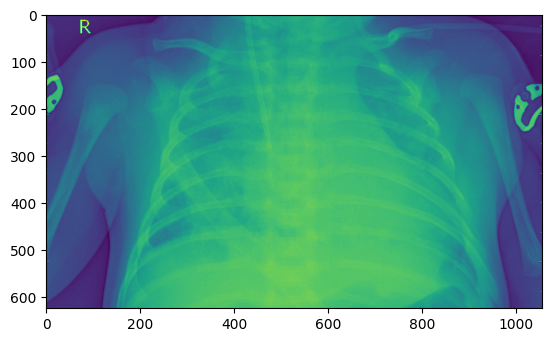

In [9]:
sample_image_1d = df_total.iloc[0]['matrix']
imshow(np.asarray(sample_image_1d))

In [10]:
sample_image.shape

(624, 1056, 3)

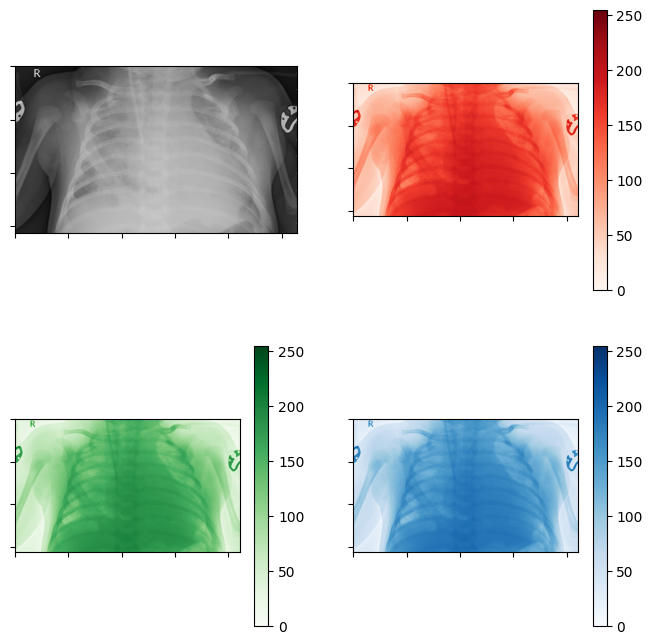

In [11]:
# We print the three arrays Red, Green, Blue (R,G,B)
img = sample_image

# Split
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

# Plot
fig, axs = plt.subplots(2,2, figsize=(8,8))
cax_00 = axs[0,0].imshow(img/255)  # carefull with this line. As usual there are issues with the formats Keras is [0..1]
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

In [12]:
df_total['matrix'] = df_total['image'].apply(lambda x: cv2.imread(x))
df_total['shapes'] = df_total['matrix'].apply(lambda x: x.shape)

In [13]:
# images come on different sizes
df_total['shapes']

0        (624, 1056, 3)
1        (731, 1134, 3)
2        (768, 1280, 3)
3       (1376, 1520, 3)
4        (752, 1160, 3)
             ...       
4094    (1148, 1416, 3)
4095    (1464, 1600, 3)
4096    (1302, 1518, 3)
4097     (998, 1392, 3)
4098     (804, 1156, 3)
Name: shapes, Length: 4099, dtype: object

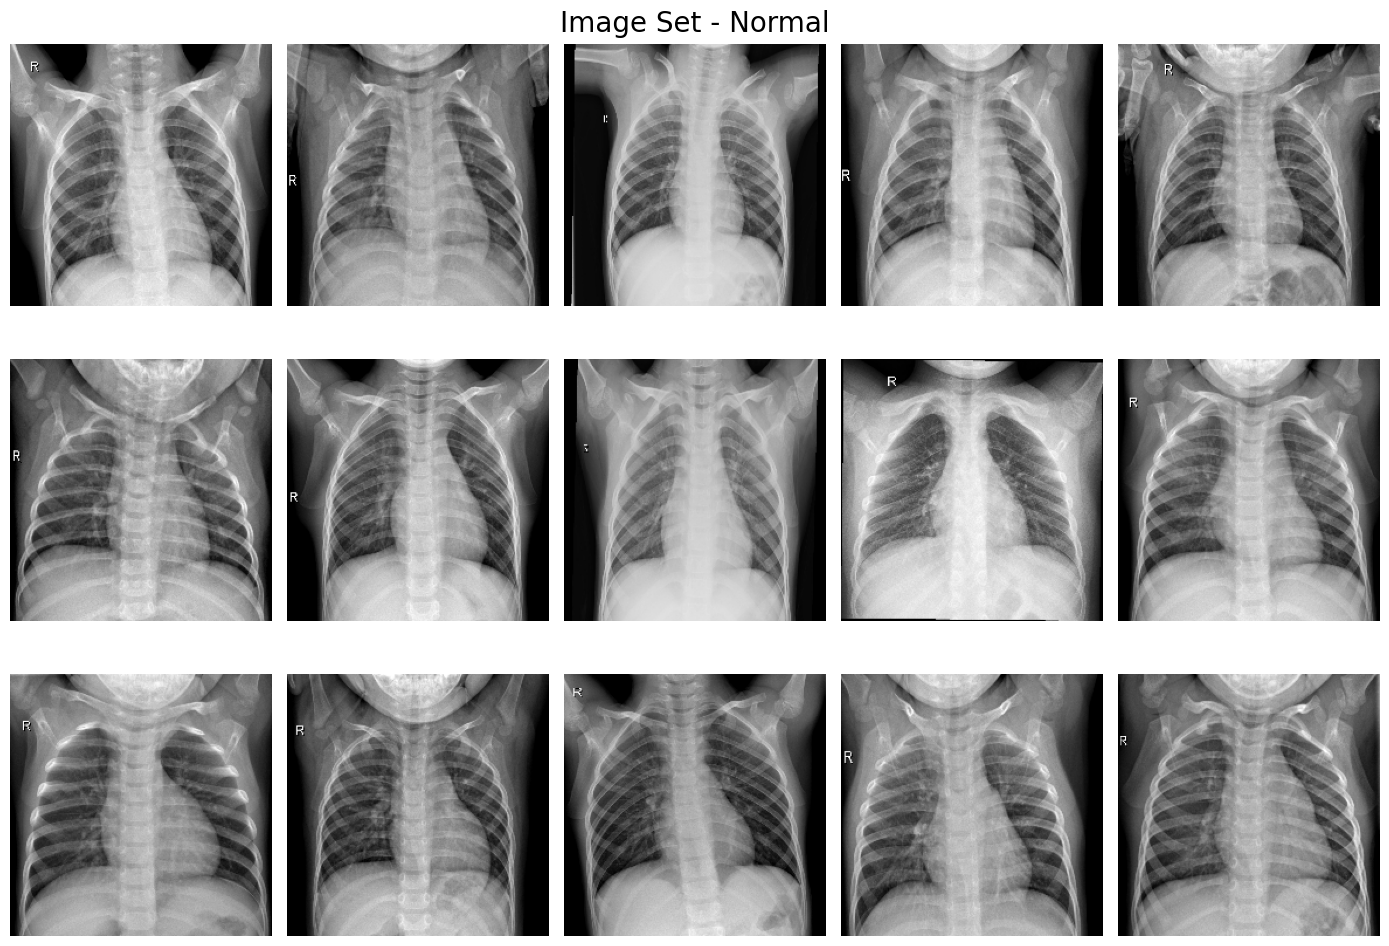

In [15]:
#Image Set - Normal

#normal_images = df_total.loc[df_total['class'] == 'normal'], 'image'].tolist()

df_tmp = df_total[df_total['class'] == 'Normal']
normal_images =df_tmp['image'].tolist()


plt.figure(figsize=(14,10))

for i in range(0, 15):
    plt.subplot(3,5,i + 1)
    img = cv2.imread(normal_images[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Image Set - Normal', size=20)

plt.show()

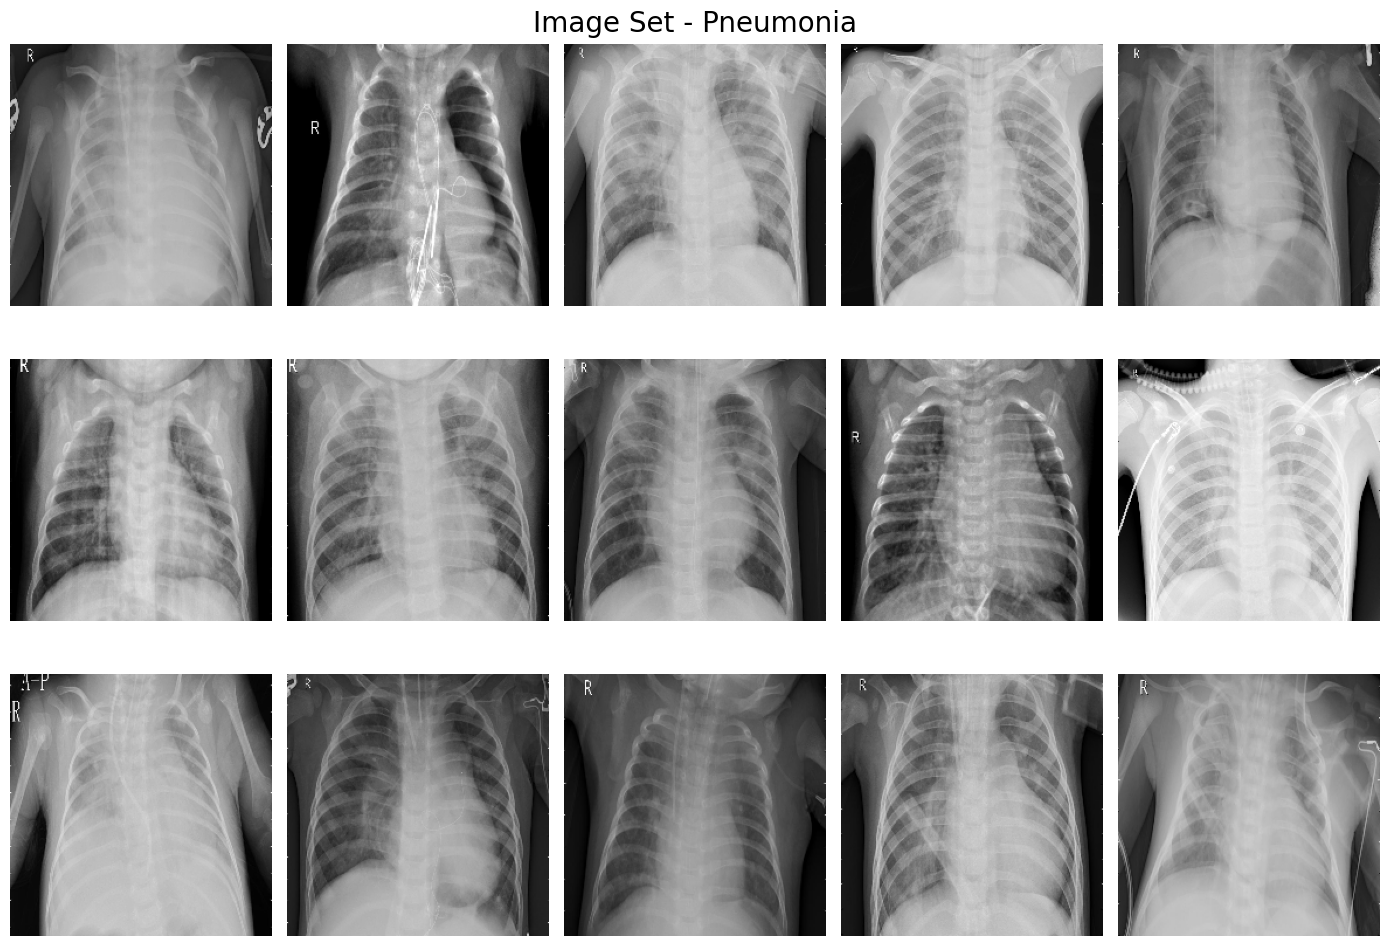

In [16]:
#Image Set - Pneumonia

#normal_images = df_total.loc[df_total['class'] == 'normal'], 'image'].tolist()

df_tmp = df_total[df_total['class'] == 'Pneumonia']
normal_images =df_tmp['image'].tolist()


plt.figure(figsize=(14,10))

for i in range(0, 15):
    plt.subplot(3,5,i + 1)
    img = cv2.imread(normal_images[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Image Set - Pneumonia', size=20)

plt.show()

In [17]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
cv2                 4.11.0
matplotlib          3.9.2
numpy               1.26.4
pandas              2.2.3
seaborn             0.13.2
session_info        1.0.0
sklearn             1.5.2
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-18 11:32
